In [1]:
import torch
import torch.utils.data as data
import os
import pickle
import numpy as np
import nltk
from PIL import Image
# from build_vocab import Vocabulary
import json
import shutil
import utils
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
import utils
import spacy    
import itertools
import collections
cuda = torch.cuda.is_available()
cuda

False

#### Fetch Data

In [2]:
nlp = spacy.load('en_core_web_lg')

In [3]:
im_path_arch = "/Users/manuelladron/phd_cd/DL_11785/project/data_collection/architecture/thumbs/big"
im_path_des = "/Users/manuelladron/phd_cd/DL_11785/project/data_collection/design/design/thumbs/big"
im_path_tech = "/Users/manuelladron/phd_cd/DL_11785/project/data_collection/technology/thumbs/big"

tagged_path_arch = "../data/architecture_dz-cleaned-tagged.json"
tagged_path_des = "../data/design_dz-cleaned-tagged.json"
tagged_path_tech = "../data/technology_dz-cleaned-tagged.json"

vocab_path_arch = "../data/architecture_dz-cleaned.json"
vocab_path_des = "../data/design_dz-cleaned.json"
vocab_path_tech = "../data/technology_dz-cleaned.json"

im_paths = [im_path_arch, im_path_des, im_path_tech]
paths_for_vocab = [vocab_path_arch, vocab_path_des, vocab_path_tech]
tagged_files_paths = [tagged_path_arch, tagged_path_des, tagged_path_tech]
im_toy = [im_path_tech]
tagg_toy = [tagged_path_tech]

dataset_new_folder = "/Users/manuelladron/phd_cd/DL_11785/project/Github_Ambiguity-in-Computational-Creativity-master/multilabel_classifier/dataset/images"
vocab_dict_path = "/Users/manuelladron/phd_cd/DL_11785/project/Github_Ambiguity-in-Computational-Creativity-master/data/vocab/vocab-dict.json"

In [4]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self, nlp):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
        self.nlp = nlp

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)
    
    
    def get_adj_from_sentence(self, sentence):
        """
        Parses sentence and get a list of cleaned lemmatized adj longer than 1 character. No duplicates
        """
        doc = self.nlp(sentence)
        adj = []
        for token in doc:
            if token.pos_ == 'ADJ':
                adj_ = token.lemma_.lower()
                if len(adj_) > 1:
                    adj.append(adj_)
#         print("adj: ", adj)
        return list(set(adj))
        
    def get_adj_from_all_sentences(self, sentences):
        """
        Calls the function get_adj_from_sentence a sentences number of times
        """
        adj = []
        for sentence in sentences:
#             print("sentence: ", sentence)
            sent_adj = self.get_adj_from_sentence(sentence)
            adj.extend(sent_adj)
        return adj

In [5]:
def build_vocabulary(path, save_dict_path, nlp):
    """
    Builds vocabulary with the entirity of the datasets
    """
    
    # Create Utils instance
    U = utils.Utils()
    data_raw = U.jsons_to_list(path)
    
    # Create a vocab wrapper and add some special tokens.
    vocab = Vocabulary(nlp)
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>') 

    all_adjs = []
    for f, file in enumerate(data_raw): # 0_arch 1_des 2_...
        print("Starting building vocab corresponding to file: \n", f)
        for i in range(len(file)): # 900 samples
            sample_dict = file[i]                             
            sample_text = sample_dict['text'] # this is a list with strings
            adj_list = vocab.get_adj_from_all_sentences(sample_text)
            all_adjs.append(adj_list)
        print("....Finishing vocab file: \n", f)

    for sublist in all_adjs:
        for adj in sublist:
            vocab.add_word(adj)
            
    # Save vocab in dict 
    with open(vocab_dict_path, 'wb') as f:
        pickle.dump(vocab, f)
    f.close()
    return vocab

In [6]:
def load_vocab(file_path):
    
    # open file
    f = open(file_path, 'rb')
    
    # dump info to that file
    data = pickle.load(f)
    
    # close file
    f.close()
    
    # return vocab
    return data

In [7]:
VOCAB = load_vocab(vocab_dict_path)

In [8]:
len(VOCAB)

7264

In [ ]:
# VOCAB = build_vocabulary(paths_for_vocab, vocab_dict_path, nlp)
# print("len of VOCAB: ", len(VOCAB))

In [121]:
ALPHABET = 'abcdefghijklmnopqrstuvwxyz'
NUMBERS = '0123456789'

class PreprocessedData(object):
    def __init__(self, files_paths, images_paths, new_folder, nlp, vocab):
        """
        train_file_path = list with files
        test_file_path = list with files
        """
        
        # Create pipe
        self.nlp = nlp
        
        # Inherit vocabulary
        self.VOCAB = vocab
        
        # Call to utils
        self.Utils = utils.Utils()
        
        # paths to jsons
        self.files_paths = files_paths
        
        # path to image folders
        self.images_paths = images_paths

        # path to new image_path
        self.new_image_path = new_folder
        
        # Dataset
        self.train_data = None 
        self.dev_data = None
        self.train_labels = None
        self.dev_labels = None
        
        # Run
        print("\nRunner....")
        self.runner()
        
    ############## PROCESSING DATA ##############
    def get_adj_from_sentence(self, sentence):
        """
        Parses sentence and get a list of cleaned lemmatized adj longer than 1 character. No duplicates
        """
        doc = self.nlp(sentence)
        adj = []
        for token in doc:
            if token.pos_ == 'ADJ':
                adj_ = token.lemma_.lower()
                if len(adj_) > 1:
                    adj.append(adj_)
        return list(set(adj))
        
    def get_adj_from_all_sentences(self, sentences):
        """
        Calls the function get_adj_from_sentence a sentences number of times
        """
        adj = []
        for sentence in sentences:
            sent_adj = self.get_adj_from_sentence(sentence)
            adj.extend(sent_adj)
        return adj
        
    def is_valid(self, images, adj):
        """
        Avoids empty data samples
        """
        if adj == []: return False
        if images == []: return False
        return True
    
    
    def handle_N_labels(self, list_of_labels, N_labels):
        """
        Truncates or pads list of labels according to N_labels
        """
        pad_with = list_of_labels[0]
        if len(list_of_labels) == N_labels:
            return list_of_labels
        
        elif len(list_of_labels) < N_labels:
            diff = N_labels - len(list_of_labels)
            for i in range(diff):
                list_of_labels.append(pad_with)
        else:
            list_of_labels = list_of_labels[:N_labels]
        
        return list_of_labels
    
    def get_images_labels(self, files):
        """
        Parse json files and outputs train_data (image) + numpy array labels for multi-label classification
        """
        train_data = []
        labels = dict()
        
        for f, file in enumerate(files): # 0_arch 1_des 2_tech
            im_per_section = []     # these ones have the same length
            for i in range(len(file)): # 902 samples architecture, 675 samples design  
                sample_dict = file[i]                  # dictionary
                sample_text = sample_dict['text']      # list with sentences (strings)
                text_tags = sample_dict['text-tags']
                sample_images = sample_dict['images']
                image_tags = sample_dict['image-tags']
                  
                # 2) Select valid text
                tagged_text = [sample_text[ALPHABET.index(letter)].lower() for letter in text_tags]
                
                # 3) Get adjectives from valid text
                adj = self.get_adj_from_all_sentences(tagged_text)
                
                # 4) Select valid images
                tagged_images = [sample_images[int(letter)] for letter in image_tags]
                
                if self.is_valid(tagged_images, adj):
                    # Add special token '<end>' as a label
#                     adj.append('<end>')
#                     adj = self.handle_N_labels(adj, 3)
                    for image in tagged_images:
                        labels[image[5:]] = adj
                    im_per_section.append(tagged_images)
            
            train_data.append(im_per_section)

        return train_data, labels
                    
    def convert_labels_to_int(self, labels):
        """
        Convert labels to int array
        """
        self.labels_int = dict()
        for key, val in labels.items():
            label_array = np.zeros(len(val), dtype = int)
            for i, label in enumerate(val):
                # Try add label in vocabulary. If already exists, nothing happens, just get the idx
                self.VOCAB.add_word(label)
                idx = self.VOCAB.word2idx[label]
                label_array[i] = idx
            self.labels_int[key] = label_array
        
        return self.labels_int
    
    def copy_wrapper(self, list_dataset_per_section, curr_folders, dest_folder):
        self.all_failed_samples = []
        for i, dataset in enumerate(list_dataset_per_section):
            self.all_failed_samples.append(self.copy_dataset(dataset, curr_folders[i], dest_folder))
        
    def copy_dataset(self, image_dataset, curr_folder, dest_folder):
        fail_samples = self.Utils.copy_files(image_dataset, curr_folder, dest_folder)
        return fail_samples
    
    def flatten(self, S):
        if S == []:
            return S
        if isinstance(S[0], list):
            return self.flatten(S[0]) + self.flatten(S[1:])
        return S[:1] + self.flatten(S[1:])
    
    def change_name(self, dataset):
        dataset = self.flatten(dataset)
        for i, image in enumerate(dataset):
            newname = image[5:]
            dataset[i] = newname
        return dataset
            
    def remove_dups(self):
        seen = []
        dups = []
        for sample in self.train_data:
            if sample not in seen:
                seen.append(sample)
            else:
                dups.append(sample)
        
        for dup in dups:
            if dup in self.train_data:
                self.train_data.remove(dup)
    
    def partition_data(self, data_set, label_set, train_percentage):
        train_len = int(train_percentage*data_set.size)
        dev_len = data_set.size - train_len

        # train
        train_set = data_set[:train_len]
        train_labels = label_set[:train_len]

        # development
        dev_set = data_set[train_len:]
        dev_labels = label_set[train_len:]

    def runner(self):
        files = self.Utils.jsons_to_list(self.files_paths)    
        self.train_data, self.labels = self.get_images_labels(files) # keep track of the length of these variables
        
        # This puts all the images in one folder. 
        self.copy_wrapper(self.train_data, self.images_paths, self.new_image_path)
        
        # Change names of self.train
        self.train_data = self.change_name(self.train_data)
        
        # This needs to be done after flattening
        self.convert_labels_to_int(self.labels)
        
        # Removes potential duplicates
        self.remove_dups()


In [107]:
dataset = PreprocessedData(tagged_files_paths, im_paths, dataset_new_folder, nlp, VOCAB)

Utils object created...

Runner....
Json_file: 0, length: 902, type: <class 'list'>
Json_file: 1, length: 888, type: <class 'list'>
Json_file: 2, length: 166, type: <class 'list'>
Done!
Done!
Done!


In [122]:
dataset_toy = PreprocessedData(tagg_toy, im_toy, dataset_new_folder, nlp, VOCAB)

Utils object created...

Runner....
Json_file: 0, length: 166, type: <class 'list'>
Done!


In [123]:
dataset= dataset_toy

In [108]:
len(dataset.train_data), len(dataset.labels)

(4907, 4907)

In [109]:
dataset.train_data[2]

'77768d2fcb5367b4786813059029a7e886a13dde.jpg'

In [124]:
dataset.labels

{'c2b73812c1686fd3722bd1f6b31e8f81977dff30.jpg': ['effective', 'protective'],
 'fe4e187663e2edc4d5b97032f2e5f9825c6bfd96.jpg': ['effective', 'protective'],
 '08bfed2dacc6194bba6feb38cc78f36da0bf5d96.jpg': ['effective', 'protective'],
 'bb6e9a13535edc716d01c7b05e63d8f5cb8f7165.jpg': ['social',
  'traditional',
  'static',
  'broad',
  'tangible',
  'many',
  'dutch',
  'large'],
 '21c1ad10ae1b1214eaaf8dce7ce337ee33337926.jpg': ['social',
  'traditional',
  'static',
  'broad',
  'tangible',
  'many',
  'dutch',
  'large'],
 '5f928f721b567fff8aa774bf51c97dcb6084fb0d.jpg': ['social',
  'traditional',
  'static',
  'broad',
  'tangible',
  'many',
  'dutch',
  'large'],
 '2a4cb1f702b7d233df434f5f56d2e3de8d8fe8fe.jpg': ['social',
  'traditional',
  'static',
  'broad',
  'tangible',
  'many',
  'dutch',
  'large'],
 'fb7cd61519adc109ee9d849c2a759be6e9e0f116.jpg': ['social',
  'traditional',
  'static',
  'broad',
  'tangible',
  'many',
  'dutch',
  'large'],
 'c04bc72a5a2d0214ea2d9c2aee929

In [92]:
def see_images(N):
    # Read using Pillow
    for i in range(N):
        name = dataset_new_folder + "/" + dataset.train_data[i+1000]
        image = np.array(Image.open(name))
        print(image.shape)
        plt.imshow(image)
        plt.show()

(85, 128, 3)


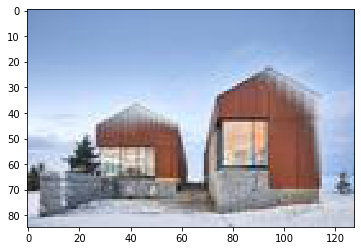

(128, 97, 3)


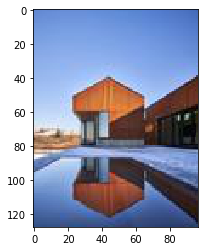

(96, 128, 3)


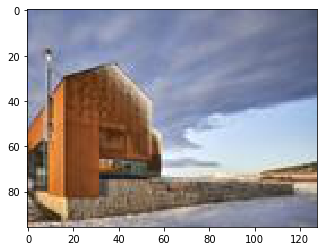

In [93]:
see_images(3)

In [126]:
class ImageDataset(Dataset):
    def __init__(self, dataset):
        self.data = dataset
        self.image_labels_string = dataset.labels    # dictionary
        self.image_labels_int = dataset.labels_int
        self.image_names = dataset.train_data  # list with image_names
        self.name2idx()
        
    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        image_name = self.idx2name[index]
        name = dataset_new_folder + "/" + self.image_names[index]
        img = Image.open(name)
        
        img = transforms.Compose([
        transforms.Resize((64, 64)),
#         transforms.RandomResizedCrop(100),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])(img)
        
        label = torch.from_numpy(self.image_labels_int[image_name])
        return img, label
    
    def name2idx(self):
        self.name2idx = dict()
        self.idx2name = dict()
        for i, key in enumerate(self.image_labels_string.keys()):
            self.name2idx[key] = i
            self.idx2name[i] = key
            
def collate(sequence):
    """
    "the input of this function is the output of function __getitem__"
    "this gets BATCH_SIZE times GETITEM! "
    if batch_Size == 2 --> sequence is a list with length 2. 
    Each list is a tuple (image, label) = ((3,64,64), label_length)
    """

    """
    print("\nCollate function....")
    print("Sequence: ")
    print(len(sequence))
    print("seq[0] = ", sequence[0][0].shape, sequence[0][1].shape)
    print("")
    print("Seq[1] = ", sequence[1][0].shape, sequence[1][1].shape)
    """
    
    # Concatenate all images in the batch
    inputs = torch.cat(([  batch_[0].view(-1, 3, 64, 64) for batch_ in sequence]), dim=0)
    
    # Pad labels with max_sequence_label
    targets  = pad_sequence([batch_[1] for batch_ in sequence], batch_first=True)
    targets_length  = torch.LongTensor([len(batch_[1]) for batch_ in sequence])     
    
#     print("\nInputs: {}\nTargets: {}\nTargets length:{}\n".format(len(inputs), targets.shape, targets_length))
    return inputs, targets, targets_length


In [127]:
dataset_processed = ImageDataset(dataset)

In [128]:
for x in dataset_processed:
    train_data_item, train_data_label = dataset_processed.__getitem__(1000)

KeyError: 1000

In [ ]:
train_data_label

In [129]:
train_data_item.shape, train_data_label.shape

(torch.Size([3, 64, 64]), torch.Size([7]))

In [21]:
len(dataset_processed)

4907

In [130]:
def partition_numbers(percentage, datalen):
    train_set_n = int(datalen*percentage)
    val_set_n = datalen - train_set_n
    return train_set_n, val_set_n

In [131]:
train_n, val_n = partition_numbers(.7, len(dataset_processed))

In [132]:
train_set, val_set = torch.utils.data.random_split(dataset_processed, [train_n, val_n])

In [133]:
len(train_set), len(val_set)

(346, 149)

In [134]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [173]:
class DECODER(nn.Module):
    """
    The only combination I get to work is using the output of the LSTM, not the hiddens. 
    Can be either 1 direction or 2.
    
    """

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
                 bidirectional, dropout, max_seq=5):
        super(DECODER, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.max_seq = max_seq
        
        # embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = 0)

        # lstm layer
        self.lstm = nn.LSTM(embedding_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional,
                           dropout=dropout,
                           batch_first=True)

        # linear layer
        multiplier = 2 if bidirectional else 1
#         input_size = hidden_dim * (n_layers * multiplier) # ---> if using hiddens (n_layers important)
        input_size = hidden_dim * (multiplier) # --------------> nlayers is not correct here! think of diagram!
        self.fc = nn.Linear(input_size, output_dim)
            
            
    def forward_process(self, image_feature, labels, labels_lengths):
        print("\n----FORWARD----")
        # embedding_size = 64
        
        # labels = [batch size, max_length]
        # image_feature is [batch_size, embedding size]
        print("\nimage_features as they come: ", image_feature.shape)
        
        # image feature unsqueeze(1) --> [batch_size, 1, embedding_size] 
        print("\nimage_features unsqueeze(1): ", image_feature.unsqueeze(1).shape)
        
        print("\nLabels as they come: ", labels.shape)
        embedded_label = self.embedding(labels)
        # embedded_label = [batch size, label_len, emb dim] ---> say [2, 5, 64] : 64 dimensions for each of the 5 labels 
        print("\nAfter embedding layer: ", embedded_label.shape)
        
        # Concatenate image_feature + label_feature
        embeddings = torch.cat((image_feature.unsqueeze(1), embedded_label), 1)
        # embedding = [batch_size, length of label + 1 (dim of image), 64]
        print("\nAfter concatenating image + caption: ", embeddings.shape)
        
        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embeddings, labels_lengths, enforce_sorted=False, batch_first=True)
        #packed_embdded = [XXXX, emb dimension]
#         print("\nAfter packing the embedding layer: ", packed_embedded[0].shape)

        packed_output, (hidden, cell) = self.lstm(packed_embedded)
#         packed_output, (hidden, cell) = self.lstm(embeddings)
        #hidden = [batch size, num layers * num directions, hid dim]
        #cell = [batch size, num layers * num directions, hid dim]
        print("\nPacked output of LSTM: ", packed_output[0].shape)
        # packed output -> [8, 1024]
        # concat the final forward and backward hidden state
        
        # hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1) # THIS WAS WORKING
        hiddens = [hidden[-i,:,:] for i in range(hidden.shape[0])]
        hidden = torch.cat(hiddens, dim = 1)
        print("\nHidden shape: ", hidden.shape)
        #hidden = [batch size, hid dim * num directions]
        
        dense_outputs = self.fc(packed_output[0])
#         dense_outputs = self.fc(hidden)
#         print("\ndense outputs: ", dense_outputs.shape)

        return dense_outputs

    def forward(self, image_feature, labels, labels_lengths):
        # embedding_size = 64
        
        # --------------------------------   SHAPES -----------------------------------------------------
        # labels ----------------------> [batch size, max_length]  they come padded to go through the data loader
        # image_feature is ------------> [batch_size, embedding size]
        # image feature unsqueeze(1) --> [batch_size, 1, embedding_size] 
        # embedded_label --------------> [batch size, max_length, emb dim] (64 dimensions for each of the 5 labels)
        # embeddings (img + labels) ---> [batch_size, max_length + 1 (dim of image), embedding_shape]
        # packed_embdded --------------> [XXXX, emb dimension]
        # out lstm shape --------------> [seq_len, batch_size, hidden_dim * directions (2 if bidirectional else 1)])
        # Hidden lstm shape -----------> [batch_size, hidden_size*num_layers])
        # Cell lstm shape -------------> [directions * layers, batch_size, hidden_size])
        
        embedded_label = self.embedding(labels)

        # Concatenate image_feature + label_feature
        embeddings = torch.cat((image_feature.unsqueeze(1), embedded_label), 1)
        
        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embeddings, labels_lengths, 
                                                            enforce_sorted=False, batch_first=True)

        # IMPORTANT: The lstm input is the packed version of the concatenation of image + label embedding!
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        
        # concat the final forward and backward hidden state --> NOT USING THIS ONE
        hiddens = [hidden[-i,:,:] for i in range(hidden.shape[0])]
        hidden = torch.cat(hiddens, dim = 1)

        dense_outputs = self.fc(packed_output[0])

        return dense_outputs
    
    def sample_topk(self, features, k=3):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        
        hiddens, states = self.lstm(inputs)          # hiddens: (batch_size, 1, hidden_size)
        outputs = self.fc(hiddens.squeeze(1))                # outputs:  (batch_size, vocab_size)
        _, predicted = outputs.topk(k)                       # predicted: (batch_size)
        print("predicted: ", predicted)
        sampled_ids.append(predicted.tolist()[0])
        print(sampled_ids)
        return sampled_ids
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        
        
        for i in range(self.max_seq):                            # MAX SEQ LENGTH TO GENERATE LABELS
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.fc(hiddens.squeeze(1))                # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            print("predicted: ", predicted)
            sampled_ids.append(predicted)
            
            # Update inputs 
            inputs = self.embedding(predicted)                   # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [174]:
batch_size = 32
num_workers = 8 if cuda else 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [137]:
train_dataloader = DataLoader(train_set, batch_size=batch_size, collate_fn = collate, shuffle=True, num_workers=num_workers, drop_last=False)
val_dataloader = DataLoader(val_set, batch_size=batch_size, collate_fn = collate,shuffle=True, num_workers=num_workers, drop_last=True)


In [138]:
for d in train_dataloader:
    print(d[1], d[1].shape)
    break

tensor([[ 321, 2615,  221, 2498,  515,  884,  127,    0,    0,    0,    0,    0,
            0],
        [ 300,  187,  111,  158,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 321, 2615,  221, 2498,  515,  884,  127,    0,    0,    0,    0,    0,
            0],
        [ 260,  111,  229,  503,  117, 7204,  844,    0,    0,    0,    0,    0,
            0],
        [ 844,   16,   11, 2785,  844,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 347,   66, 4259,    7, 2617,  369,  130,    0,    0,    0,    0,    0,
            0],
        [  92, 2125,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 177,  122,   16,  320,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  11,  577,   68,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [1049,   82,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 347, 2218,   53,   4

In [175]:
## DIMENSIONS ###
embedding_dim = 64
num_hidden_nodes = 512
DEVICE = torch.device("cuda" if cuda else "cpu")
print(DEVICE)

size_of_vocab = len(dataset.VOCAB)
num_output_nodes = size_of_vocab

num_layers = 3
bidirection = True
dropout = 0
nepochs = 20
lr = 0.001
weight_decay = 0.00001

# Instantiate
encoder = EncoderCNN(embedding_dim)
decoder = DECODER(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes,
                   num_layers, bidirectional=bidirection, dropout=dropout)

# Criterion & Optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(decoder.parameters(), lr=lr, weight_decay=weight_decay)

cpu


In [141]:
def train(loader, encoder, decoder, criterion, optimizer, epoch, num_epochs):
    # Place model into mode and onto correct device
    decoder.train()
    decoder.to(device=DEVICE)

    running_loss = 0.0
    total_step = len(loader)
    for i, (images, captions, lengths) in enumerate(loader):
        # Zero gradients
        optimizer.zero_grad()
        
        images = images.to(device)
        captions = captions.to(device) # --> they come padded, so we need to pack it to get an array of labels  
        targets = nn.utils.rnn.pack_padded_sequence(captions, lengths, 
                                                        batch_first=True, enforce_sorted=False)[0]

        # Econde image with CNN
        features = encoder(images)
        
        # Get model outputs
        outputs = decoder(features, captions, lengths) # <---- main function of the whole training
        
        # Calculate loss & accuracy
        loss = criterion(outputs, targets)
        decoder.zero_grad()
        encoder.zero_grad()      
        
        # Calculate loss & accuracy
        running_loss += loss.item()

        # Compute gradients and take step
        loss.backward()
        optimizer.step()
        
        # Print log info
        if i % 10 == 0 and i != 0:
            perplexity = np.exp(loss.item()/i)
            print('Epoch [{}/{}], Batch [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch+1, num_epochs, i, total_step, loss.item(), perplexity)) 

    running_loss /= len(loader)
    
    return running_loss, perplexity

In [145]:
def test(loader, encoder, decoder, criterion, epoch, num_epochs):
    with torch.no_grad():
        # Place into eval mode
        decoder.eval()
        decoder.to(device=DEVICE)
        
        running_loss = 0.0
        perplexity = 10000
        total_step = len(loader)
        for i, (images, captions, lengths) in enumerate(loader):

            images = images.to(device)
            captions = captions.to(device) # --> they come padded, so we need to pack it to get an array of labels  
            targets = nn.utils.rnn.pack_padded_sequence(captions, lengths, 
                                                                batch_first=True, enforce_sorted=False)[0]

            # Econde image with CNN
            features = encoder(images)
        
            # Get model outputs
            outputs = decoder(features, captions, lengths) # <---- main function of the whole training

            # Calculate loss & accuracy
            loss = criterion(outputs, targets)
            running_loss += loss.item()

            # Print log info
            if i % 10 == 0 and i != 0:
                perplexity = np.exp(loss.item()/i)
                print('Epoch [{}/{}], Batch [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch+1, num_epochs, i, total_step, loss.item(), perplexity)) 
    
    running_loss /= len(loader)

    return running_loss, perplexity

In [146]:
def make_graph(epochs, train, test, train_name, val_name, name_long, name_short):

    plt.plot(epochs, train, 'g', label=train_name, c="mediumvioletred")
    plt.plot(epochs, test, 'b', label=val_name, c="darkturquoise")
    plt.title(name_long)
    plt.xlabel('Epochs')
    plt.ylabel(name_short)
    plt.legend()
    plt.show()
    

def run_epochs(encoder, decoder, optimizer, criterion, train_loader, dev_loader, n_epochs):
    train_losses, train_perplexities = [], []
    test_losses,  test_perplexities = [], []
    
    epochs = []
    
    for e in range(n_epochs):
        print('----- EPOCH ------- \n', e+1)
        
        # Train
        train_loss, train_perplexity = train(train_loader, encoder, decoder, criterion, optimizer, e, n_epochs)
        train_losses.append(train_loss)
        train_perplexities.append(train_perplexity)
        
        # Test
        test_loss, test_perplexity = test(dev_loader, encoder, decoder, criterion, e, n_epochs)
        test_losses.append(test_loss)
        test_perplexities.append(test_perplexity)
        
        # Epochs
        epochs.append(e)
        if e % 20 == 0 and e != 0:
            
            print('Training Loss: ', train_loss)
            print('Training Accuracy: ', train_acc)
            print("Train losses:\n{}\nTest losses:\n{}\n".format(train_losses, test_losses))
        
        # Make graph after each epoch
        make_graph(epochs, train_perplexities, test_perplexities, 'Training Perp', 'Testing Perp',
                   'Training and Testing Perplexity', 'Perplexity')
        make_graph(epochs, train_losses, test_losses, 'Training loss', 'Testing loss',
                   'Training and Testing loss', 'Loss')

        # save model
        torch.save(encoder.state_dict(), "./saved_models/encoder-{}.pth".format(e))
        torch.save(decoder.state_dict(), "./saved_models/decoder-{}.pth".format(e))
    
    return train_losses, test_losses, train_perplexities, test_perplexities

# path_to_load = './saved_models/v3_7.pth'
# model.load_state_dict(torch.load(path_to_load, map_location=DEVICE))


----- EPOCH ------- 
 1
Epoch [1/20], Batch [10/11], Loss: 6.1508, Perplexity: 1.8498


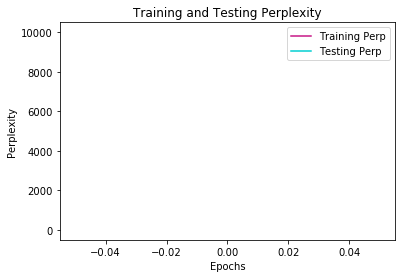

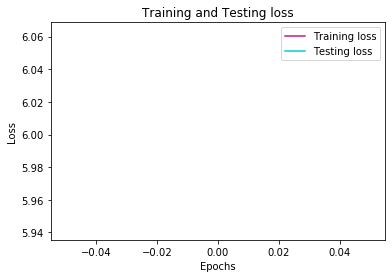

----- EPOCH ------- 
 2
Epoch [2/20], Batch [10/11], Loss: 5.5490, Perplexity: 1.7418


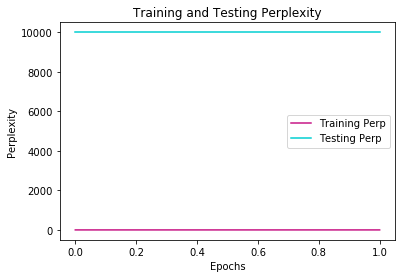

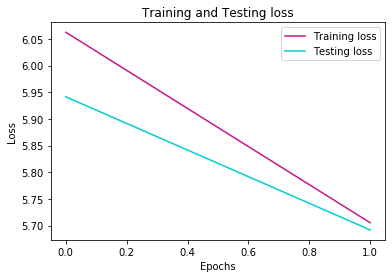

----- EPOCH ------- 
 3
Epoch [3/20], Batch [10/11], Loss: 5.6432, Perplexity: 1.7582


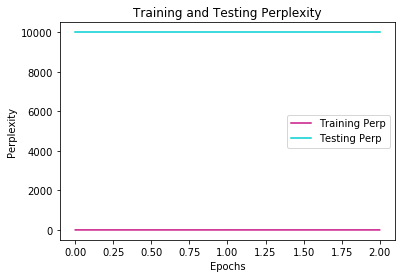

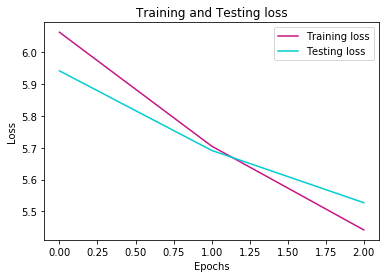

----- EPOCH ------- 
 4
Epoch [4/20], Batch [10/11], Loss: 5.2578, Perplexity: 1.6918


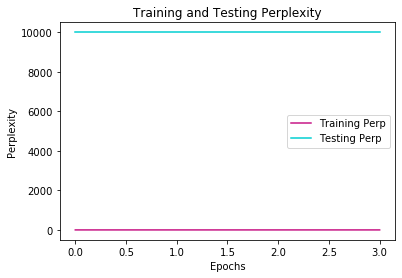

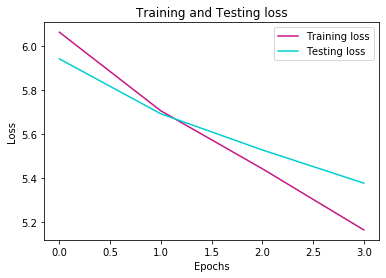

----- EPOCH ------- 
 5
Epoch [5/20], Batch [10/11], Loss: 4.6955, Perplexity: 1.5993


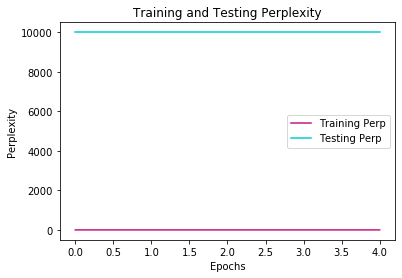

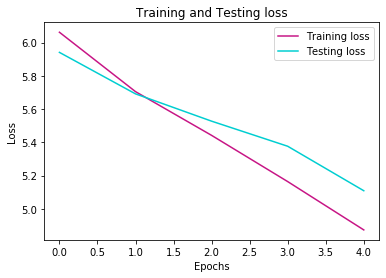

----- EPOCH ------- 
 6
Epoch [6/20], Batch [10/11], Loss: 4.5587, Perplexity: 1.5775


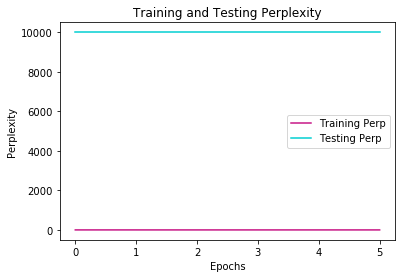

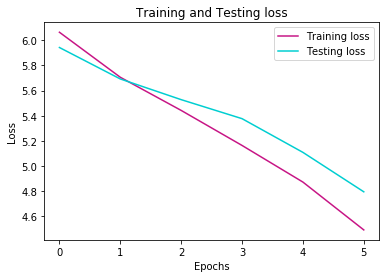

----- EPOCH ------- 
 7
Epoch [7/20], Batch [10/11], Loss: 3.6372, Perplexity: 1.4387


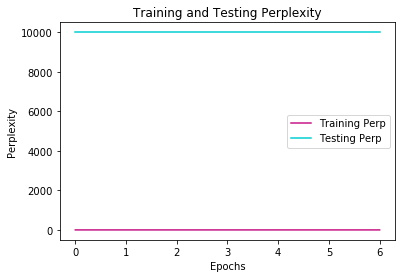

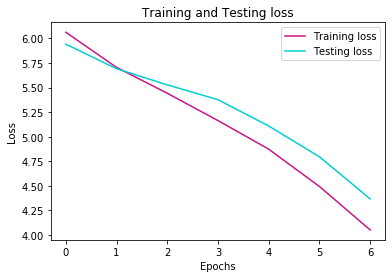

----- EPOCH ------- 
 8
Epoch [8/20], Batch [10/11], Loss: 3.1998, Perplexity: 1.3771


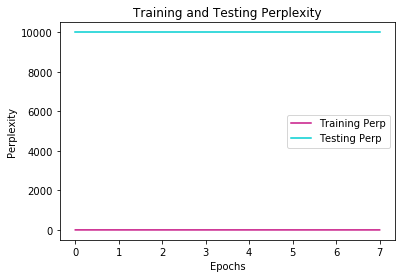

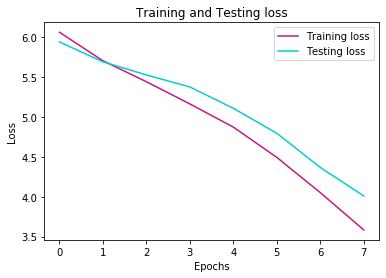

----- EPOCH ------- 
 9
Epoch [9/20], Batch [10/11], Loss: 2.8535, Perplexity: 1.3302


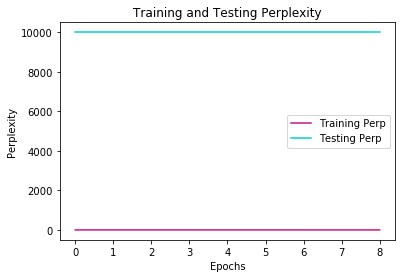

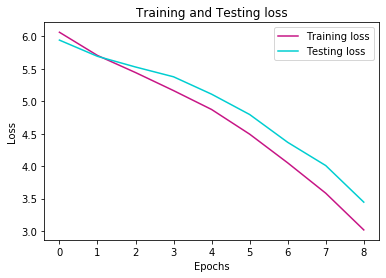

----- EPOCH ------- 
 10
Epoch [10/20], Batch [10/11], Loss: 2.8748, Perplexity: 1.3331


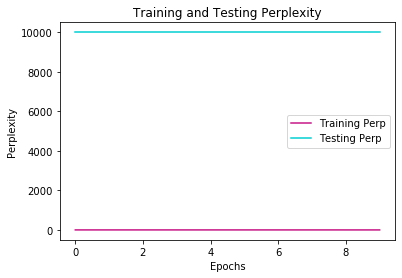

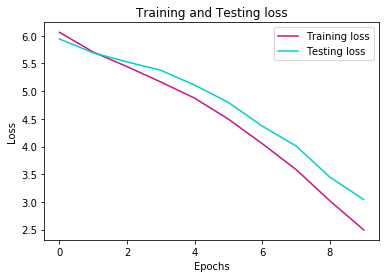

----- EPOCH ------- 
 11
Epoch [11/20], Batch [10/11], Loss: 1.9976, Perplexity: 1.2211


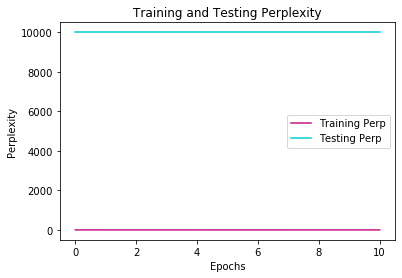

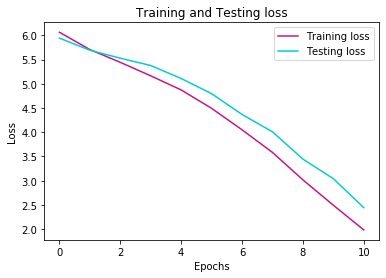

----- EPOCH ------- 
 12
Epoch [12/20], Batch [10/11], Loss: 1.1446, Perplexity: 1.1213


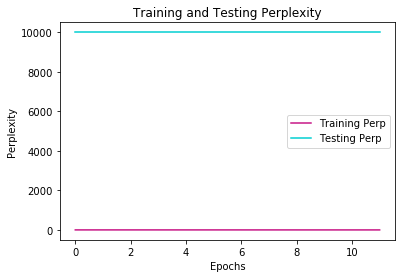

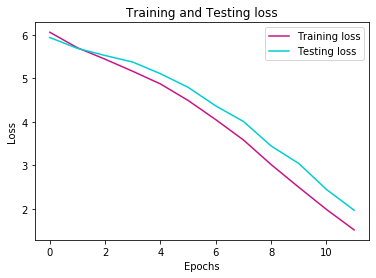

----- EPOCH ------- 
 13
Epoch [13/20], Batch [10/11], Loss: 0.9104, Perplexity: 1.0953


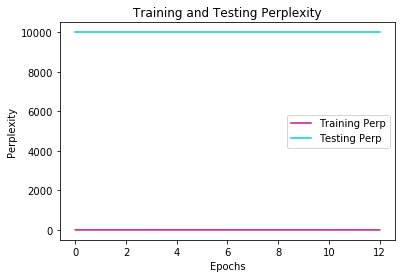

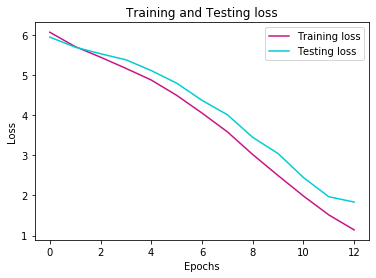

----- EPOCH ------- 
 14
Epoch [14/20], Batch [10/11], Loss: 0.8347, Perplexity: 1.0871


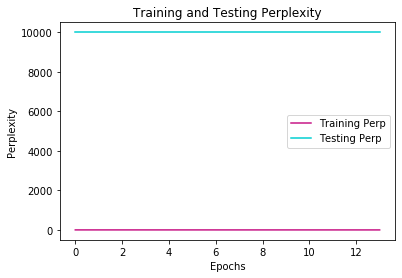

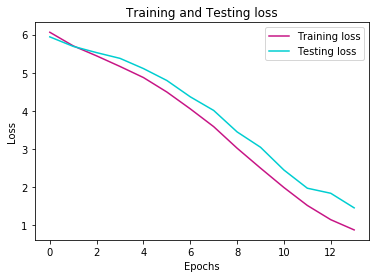

----- EPOCH ------- 
 15
Epoch [15/20], Batch [10/11], Loss: 0.6557, Perplexity: 1.0678


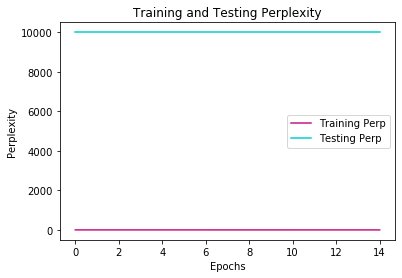

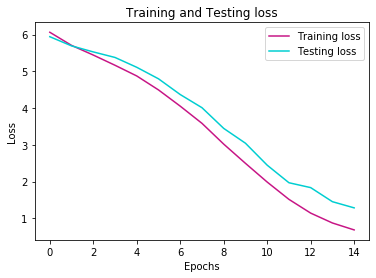

----- EPOCH ------- 
 16
Epoch [16/20], Batch [10/11], Loss: 0.3487, Perplexity: 1.0355


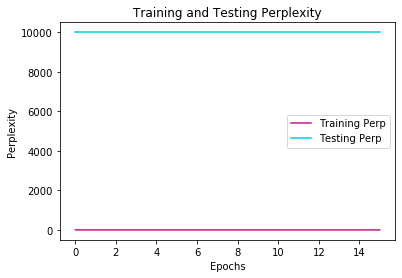

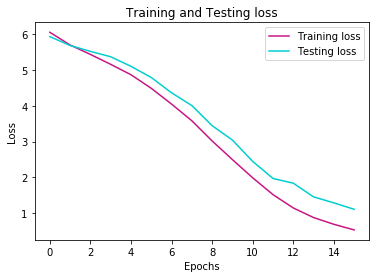

----- EPOCH ------- 
 17
Epoch [17/20], Batch [10/11], Loss: 0.2959, Perplexity: 1.0300


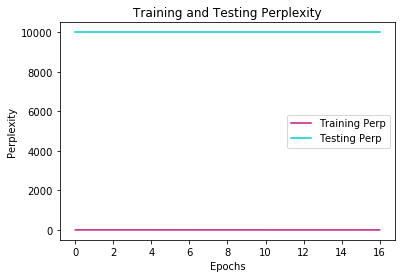

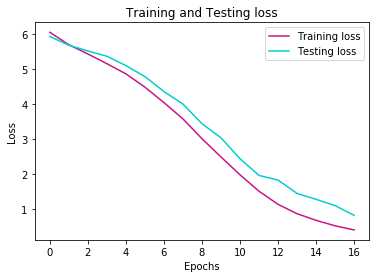

----- EPOCH ------- 
 18
Epoch [18/20], Batch [10/11], Loss: 0.3851, Perplexity: 1.0393


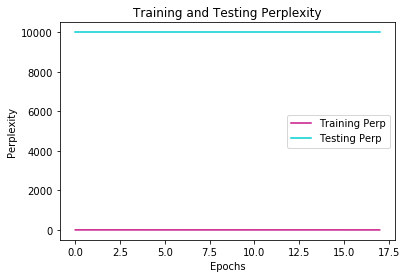

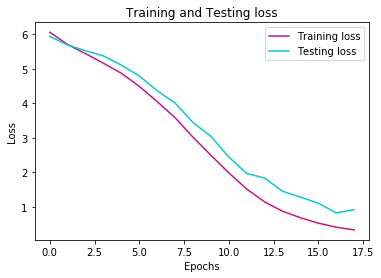

----- EPOCH ------- 
 19
Epoch [19/20], Batch [10/11], Loss: 0.1930, Perplexity: 1.0195


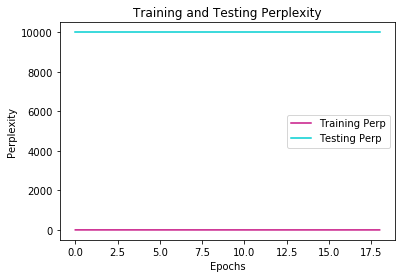

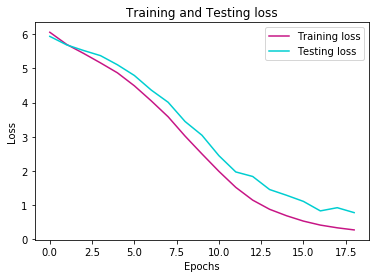

----- EPOCH ------- 
 20
Epoch [20/20], Batch [10/11], Loss: 0.1551, Perplexity: 1.0156


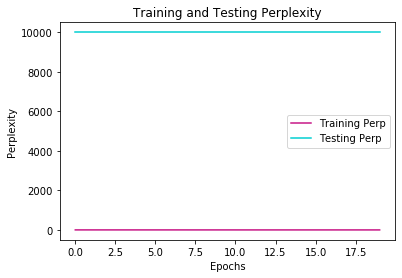

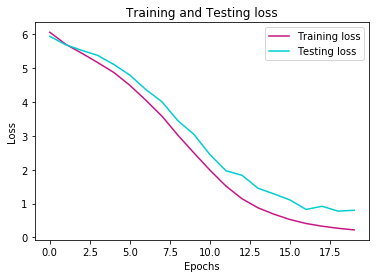

In [147]:
train_losses, test_losses, train_perplexities, test_perplexities = run_epochs(encoder, decoder, 
                                    optimizer, criterion, train_dataloader, val_dataloader, nepochs)

### Generating captions

In [176]:
def load_image(image_path, xform=None):
    image = Image.open(image_path)
    image = image.resize([64, 64], Image.LANCZOS)
    
    if xform is not None:
        image = xform(image).unsqueeze(0)
    
    return image

In [177]:
def word_ids2words(list_of_labels_ids):
    # Convert word_ids to words
    sampled_caption = []
    for word_id in list_of_labels_ids:
        word = VOCAB.idx2word[word_id]
        print("word: ", word)
        sampled_caption.append(word)
#         if word == '<end>':
#             break
    print("sampled caption: ", sampled_caption)
    sentence = ' '.join(sampled_caption)
    return sentence

In [184]:
def generate_caption_from_image(encoder, decoder, image_tensor):
    
    # Set model to eval
    encoder = encoder.eval()
    
    # Encode image
    feature = encoder(image_tensor)   
    
    # Get captions
    sampled_ids = decoder.sample_topk(feature)
    print("sampled_ids: ", sampled_ids)
    # Convert tensor to numpy in cpu
    sampled_ids = sampled_ids[0] # (1, max_seq_length) -> (max_seq_length)
    print("sampled_ids after moving to cpu and numpy: ", sampled_ids)
    return sampled_ids
    

In [185]:
def generate_labels(images):
    labels = []
    XFORMS = transforms.Compose([
        transforms.Resize((64, 64)),
        #transforms.RandomResizedCrop(100),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])
    
    # Load models 
    encoder = EncoderCNN(64)
    enc_load = './saved_models/encoder-19.pth'
    dec_load = './saved_models/decoder-19.pth'
    encoder.load_state_dict(torch.load(enc_load, map_location=DEVICE))
    decoder.load_state_dict(torch.load(dec_load, map_location=DEVICE))
    
    for image_ in images:
        # Attach path to image
#         image_name = dataset_new_folder + "/" + dataset.train_data[1]
        print("\nimage: ", image_)
        image_name = dataset_new_folder + "/" + image_
        print("image_name: ", image_name)
        # Load image and apply transformations
        image = load_image(image_name, XFORMS)
        
        # Move to proper device
        image_tensor = image.to(device)
        
        # Generate an caption from the image
        sampled_ids = generate_caption_from_image(encoder, decoder, image_tensor)
        
        # Decode ids to words
        caption = word_ids2words(sampled_ids)
        
        # Print out the image and the generated caption
        print ("\nGenerated labels: ", caption)
        image = Image.open(image_name)
        plt.imshow(np.asarray(image))
        plt.show(image)
        # Print ground truth labels
        print("\nGround truth labels: ", dataset.labels[image_])


image:  c2b73812c1686fd3722bd1f6b31e8f81977dff30.jpg
image_name:  /Users/manuelladron/phd_cd/DL_11785/project/Github_Ambiguity-in-Computational-Creativity-master/multilabel_classifier/dataset/images/c2b73812c1686fd3722bd1f6b31e8f81977dff30.jpg
predicted:  tensor([[188, 513, 158]])
[[188, 513, 158]]
sampled_ids:  [[188, 513, 158]]
sampled_ids after moving to cpu and numpy:  [188, 513, 158]
word:  real
word:  beautiful
word:  available
sampled caption:  ['real', 'beautiful', 'available']

Generated labels:  real beautiful available


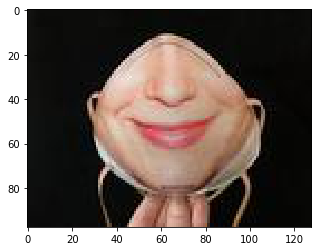


Ground truth labels:  ['effective', 'protective']

image:  fe4e187663e2edc4d5b97032f2e5f9825c6bfd96.jpg
image_name:  /Users/manuelladron/phd_cd/DL_11785/project/Github_Ambiguity-in-Computational-Creativity-master/multilabel_classifier/dataset/images/fe4e187663e2edc4d5b97032f2e5f9825c6bfd96.jpg
predicted:  tensor([[4544, 1985,  877]])
[[4544, 1985, 877]]
sampled_ids:  [[4544, 1985, 877]]
sampled_ids after moving to cpu and numpy:  [4544, 1985, 877]
word:  parasitic
word:  uber
word:  quick
sampled caption:  ['parasitic', 'uber', 'quick']

Generated labels:  parasitic uber quick


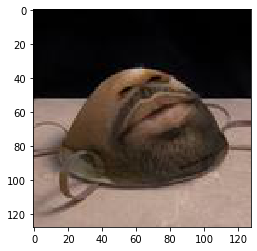


Ground truth labels:  ['effective', 'protective']

image:  08bfed2dacc6194bba6feb38cc78f36da0bf5d96.jpg
image_name:  /Users/manuelladron/phd_cd/DL_11785/project/Github_Ambiguity-in-Computational-Creativity-master/multilabel_classifier/dataset/images/08bfed2dacc6194bba6feb38cc78f36da0bf5d96.jpg
predicted:  tensor([[513, 189, 877]])
[[513, 189, 877]]
sampled_ids:  [[513, 189, 877]]
sampled_ids after moving to cpu and numpy:  [513, 189, 877]
word:  beautiful
word:  crucial
word:  quick
sampled caption:  ['beautiful', 'crucial', 'quick']

Generated labels:  beautiful crucial quick


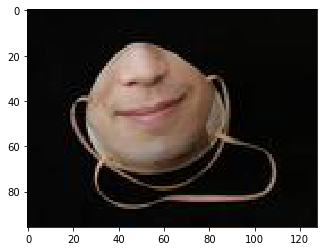


Ground truth labels:  ['effective', 'protective']

image:  bb6e9a13535edc716d01c7b05e63d8f5cb8f7165.jpg
image_name:  /Users/manuelladron/phd_cd/DL_11785/project/Github_Ambiguity-in-Computational-Creativity-master/multilabel_classifier/dataset/images/bb6e9a13535edc716d01c7b05e63d8f5cb8f7165.jpg
predicted:  tensor([[ 158, 3081, 1985]])
[[158, 3081, 1985]]
sampled_ids:  [[158, 3081, 1985]]
sampled_ids after moving to cpu and numpy:  [158, 3081, 1985]
word:  available
word:  atypical
word:  uber
sampled caption:  ['available', 'atypical', 'uber']

Generated labels:  available atypical uber


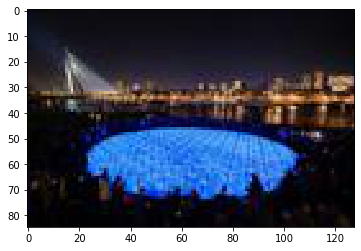


Ground truth labels:  ['social', 'traditional', 'static', 'broad', 'tangible', 'many', 'dutch', 'large']

image:  21c1ad10ae1b1214eaaf8dce7ce337ee33337926.jpg
image_name:  /Users/manuelladron/phd_cd/DL_11785/project/Github_Ambiguity-in-Computational-Creativity-master/multilabel_classifier/dataset/images/21c1ad10ae1b1214eaaf8dce7ce337ee33337926.jpg
predicted:  tensor([[ 158, 4544,  188]])
[[158, 4544, 188]]
sampled_ids:  [[158, 4544, 188]]
sampled_ids after moving to cpu and numpy:  [158, 4544, 188]
word:  available
word:  parasitic
word:  real
sampled caption:  ['available', 'parasitic', 'real']

Generated labels:  available parasitic real


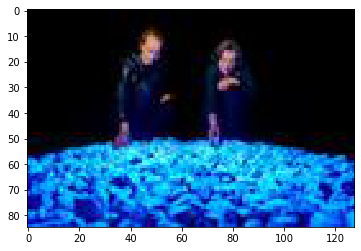


Ground truth labels:  ['social', 'traditional', 'static', 'broad', 'tangible', 'many', 'dutch', 'large']

image:  5f928f721b567fff8aa774bf51c97dcb6084fb0d.jpg
image_name:  /Users/manuelladron/phd_cd/DL_11785/project/Github_Ambiguity-in-Computational-Creativity-master/multilabel_classifier/dataset/images/5f928f721b567fff8aa774bf51c97dcb6084fb0d.jpg
predicted:  tensor([[ 158, 4544, 1985]])
[[158, 4544, 1985]]
sampled_ids:  [[158, 4544, 1985]]
sampled_ids after moving to cpu and numpy:  [158, 4544, 1985]
word:  available
word:  parasitic
word:  uber
sampled caption:  ['available', 'parasitic', 'uber']

Generated labels:  available parasitic uber


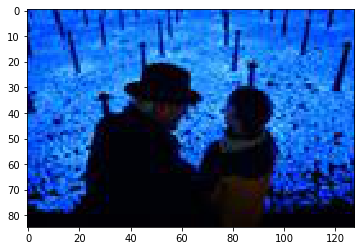


Ground truth labels:  ['social', 'traditional', 'static', 'broad', 'tangible', 'many', 'dutch', 'large']

image:  2a4cb1f702b7d233df434f5f56d2e3de8d8fe8fe.jpg
image_name:  /Users/manuelladron/phd_cd/DL_11785/project/Github_Ambiguity-in-Computational-Creativity-master/multilabel_classifier/dataset/images/2a4cb1f702b7d233df434f5f56d2e3de8d8fe8fe.jpg
predicted:  tensor([[ 158, 1985, 4544]])
[[158, 1985, 4544]]
sampled_ids:  [[158, 1985, 4544]]
sampled_ids after moving to cpu and numpy:  [158, 1985, 4544]
word:  available
word:  uber
word:  parasitic
sampled caption:  ['available', 'uber', 'parasitic']

Generated labels:  available uber parasitic


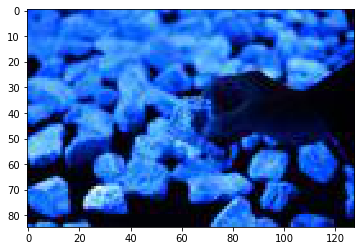


Ground truth labels:  ['social', 'traditional', 'static', 'broad', 'tangible', 'many', 'dutch', 'large']

image:  fb7cd61519adc109ee9d849c2a759be6e9e0f116.jpg
image_name:  /Users/manuelladron/phd_cd/DL_11785/project/Github_Ambiguity-in-Computational-Creativity-master/multilabel_classifier/dataset/images/fb7cd61519adc109ee9d849c2a759be6e9e0f116.jpg
predicted:  tensor([[ 158, 4544,  172]])
[[158, 4544, 172]]
sampled_ids:  [[158, 4544, 172]]
sampled_ids after moving to cpu and numpy:  [158, 4544, 172]
word:  available
word:  parasitic
word:  well
sampled caption:  ['available', 'parasitic', 'well']

Generated labels:  available parasitic well


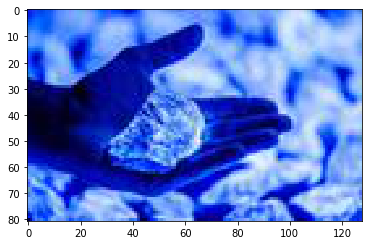


Ground truth labels:  ['social', 'traditional', 'static', 'broad', 'tangible', 'many', 'dutch', 'large']

image:  c04bc72a5a2d0214ea2d9c2aee9291a09c562a1d.jpg
image_name:  /Users/manuelladron/phd_cd/DL_11785/project/Github_Ambiguity-in-Computational-Creativity-master/multilabel_classifier/dataset/images/c04bc72a5a2d0214ea2d9c2aee9291a09c562a1d.jpg
predicted:  tensor([[ 11, 189, 513]])
[[11, 189, 513]]
sampled_ids:  [[11, 189, 513]]
sampled_ids after moving to cpu and numpy:  [11, 189, 513]
word:  new
word:  crucial
word:  beautiful
sampled caption:  ['new', 'crucial', 'beautiful']

Generated labels:  new crucial beautiful


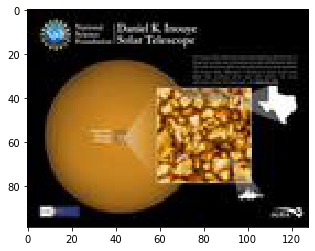


Ground truth labels:  ['turbulent', 'violent', 'solar', 'able', 'magnetic', 'solar', 'first', 'more']

image:  82158235f18fe6f9e3737b6b33edb56289f0bfd5.jpg
image_name:  /Users/manuelladron/phd_cd/DL_11785/project/Github_Ambiguity-in-Computational-Creativity-master/multilabel_classifier/dataset/images/82158235f18fe6f9e3737b6b33edb56289f0bfd5.jpg
predicted:  tensor([[ 158, 3081,  877]])
[[158, 3081, 877]]
sampled_ids:  [[158, 3081, 877]]
sampled_ids after moving to cpu and numpy:  [158, 3081, 877]
word:  available
word:  atypical
word:  quick
sampled caption:  ['available', 'atypical', 'quick']

Generated labels:  available atypical quick


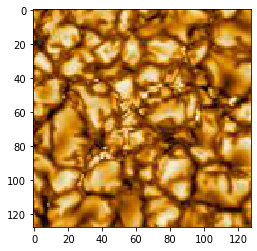


Ground truth labels:  ['turbulent', 'violent', 'solar', 'able', 'magnetic', 'solar', 'first', 'more']

image:  f5a312bdc45ca85a41603bcfa8d48ae41212c121.jpg
image_name:  /Users/manuelladron/phd_cd/DL_11785/project/Github_Ambiguity-in-Computational-Creativity-master/multilabel_classifier/dataset/images/f5a312bdc45ca85a41603bcfa8d48ae41212c121.jpg
predicted:  tensor([[1985,  877, 4544]])
[[1985, 877, 4544]]
sampled_ids:  [[1985, 877, 4544]]
sampled_ids after moving to cpu and numpy:  [1985, 877, 4544]
word:  uber
word:  quick
word:  parasitic
sampled caption:  ['uber', 'quick', 'parasitic']

Generated labels:  uber quick parasitic


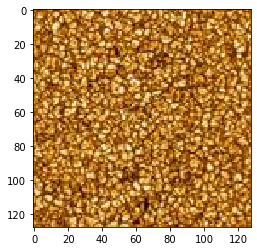


Ground truth labels:  ['turbulent', 'violent', 'solar', 'able', 'magnetic', 'solar', 'first', 'more']

image:  6ea0a7b407ab4cc41388eb62ad083afd17a659a1.jpg
image_name:  /Users/manuelladron/phd_cd/DL_11785/project/Github_Ambiguity-in-Computational-Creativity-master/multilabel_classifier/dataset/images/6ea0a7b407ab4cc41388eb62ad083afd17a659a1.jpg
predicted:  tensor([[ 172, 3081,  158]])
[[172, 3081, 158]]
sampled_ids:  [[172, 3081, 158]]
sampled_ids after moving to cpu and numpy:  [172, 3081, 158]
word:  well
word:  atypical
word:  available
sampled caption:  ['well', 'atypical', 'available']

Generated labels:  well atypical available


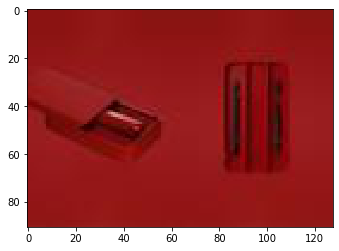


Ground truth labels:  ['scary', 'only', 'understandable', 'basic', 'intricate', 'simple', 'straightforward', 'simple', 'back', 'forward', 'confusing', 'intuitive', 'meaningless', 'symbolic', 'traditional', 'manual']

image:  19687208274a5ce3d10d0afdaf9c2e6672a4ce9e.jpg
image_name:  /Users/manuelladron/phd_cd/DL_11785/project/Github_Ambiguity-in-Computational-Creativity-master/multilabel_classifier/dataset/images/19687208274a5ce3d10d0afdaf9c2e6672a4ce9e.jpg
predicted:  tensor([[ 11, 172, 189]])
[[11, 172, 189]]
sampled_ids:  [[11, 172, 189]]
sampled_ids after moving to cpu and numpy:  [11, 172, 189]
word:  new
word:  well
word:  crucial
sampled caption:  ['new', 'well', 'crucial']

Generated labels:  new well crucial


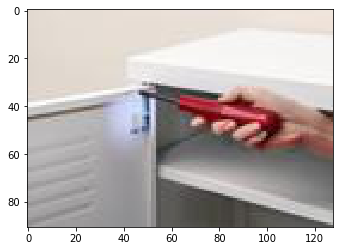


Ground truth labels:  ['scary', 'only', 'understandable', 'basic', 'intricate', 'simple', 'straightforward', 'simple', 'back', 'forward', 'confusing', 'intuitive', 'meaningless', 'symbolic', 'traditional', 'manual']

image:  080062ddb797477063d1ae77ca4a631cc5867087.jpg
image_name:  /Users/manuelladron/phd_cd/DL_11785/project/Github_Ambiguity-in-Computational-Creativity-master/multilabel_classifier/dataset/images/080062ddb797477063d1ae77ca4a631cc5867087.jpg
predicted:  tensor([[ 158,  513, 3081]])
[[158, 513, 3081]]
sampled_ids:  [[158, 513, 3081]]
sampled_ids after moving to cpu and numpy:  [158, 513, 3081]
word:  available
word:  beautiful
word:  atypical
sampled caption:  ['available', 'beautiful', 'atypical']

Generated labels:  available beautiful atypical


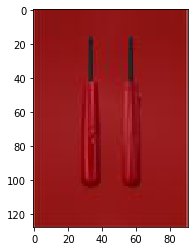


Ground truth labels:  ['scary', 'only', 'understandable', 'basic', 'intricate', 'simple', 'straightforward', 'simple', 'back', 'forward', 'confusing', 'intuitive', 'meaningless', 'symbolic', 'traditional', 'manual']

image:  c9c323cb23c1ac8ef0bb75814d6859e581e79cd5.jpg
image_name:  /Users/manuelladron/phd_cd/DL_11785/project/Github_Ambiguity-in-Computational-Creativity-master/multilabel_classifier/dataset/images/c9c323cb23c1ac8ef0bb75814d6859e581e79cd5.jpg
predicted:  tensor([[188, 172,  70]])
[[188, 172, 70]]
sampled_ids:  [[188, 172, 70]]
sampled_ids after moving to cpu and numpy:  [188, 172, 70]
word:  real
word:  well
word:  unique
sampled caption:  ['real', 'well', 'unique']

Generated labels:  real well unique


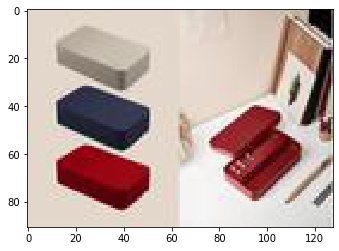


Ground truth labels:  ['scary', 'only', 'understandable', 'basic', 'intricate', 'simple', 'straightforward', 'simple', 'back', 'forward', 'confusing', 'intuitive', 'meaningless', 'symbolic', 'traditional', 'manual']

image:  e0f23718099077eec591e45233f77e88694b0ba9.jpg
image_name:  /Users/manuelladron/phd_cd/DL_11785/project/Github_Ambiguity-in-Computational-Creativity-master/multilabel_classifier/dataset/images/e0f23718099077eec591e45233f77e88694b0ba9.jpg
predicted:  tensor([[ 877, 3081, 1985]])
[[877, 3081, 1985]]
sampled_ids:  [[877, 3081, 1985]]
sampled_ids after moving to cpu and numpy:  [877, 3081, 1985]
word:  quick
word:  atypical
word:  uber
sampled caption:  ['quick', 'atypical', 'uber']

Generated labels:  quick atypical uber


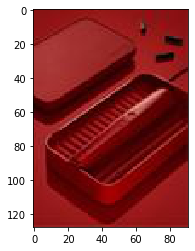


Ground truth labels:  ['scary', 'only', 'understandable', 'basic', 'intricate', 'simple', 'straightforward', 'simple', 'back', 'forward', 'confusing', 'intuitive', 'meaningless', 'symbolic', 'traditional', 'manual']

image:  d3c05ccc27e9721f75f974f04d4aef979d2791a9.jpg
image_name:  /Users/manuelladron/phd_cd/DL_11785/project/Github_Ambiguity-in-Computational-Creativity-master/multilabel_classifier/dataset/images/d3c05ccc27e9721f75f974f04d4aef979d2791a9.jpg
predicted:  tensor([[ 11, 189, 158]])
[[11, 189, 158]]
sampled_ids:  [[11, 189, 158]]
sampled_ids after moving to cpu and numpy:  [11, 189, 158]
word:  new
word:  crucial
word:  available
sampled caption:  ['new', 'crucial', 'available']

Generated labels:  new crucial available


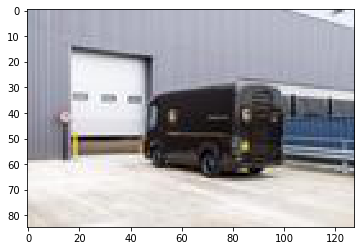


Ground truth labels:  ['electric', 'traditional', 'well', 'commercial', 'environmental', 'electric', 'compelling']

image:  5ef6d349136823da892b211ca587e2b4cf1bd4cd.jpg
image_name:  /Users/manuelladron/phd_cd/DL_11785/project/Github_Ambiguity-in-Computational-Creativity-master/multilabel_classifier/dataset/images/5ef6d349136823da892b211ca587e2b4cf1bd4cd.jpg
predicted:  tensor([[1985,  158, 3081]])
[[1985, 158, 3081]]
sampled_ids:  [[1985, 158, 3081]]
sampled_ids after moving to cpu and numpy:  [1985, 158, 3081]
word:  uber
word:  available
word:  atypical
sampled caption:  ['uber', 'available', 'atypical']

Generated labels:  uber available atypical


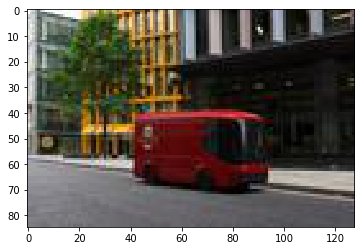


Ground truth labels:  ['electric', 'traditional', 'well', 'commercial', 'environmental', 'electric', 'compelling']

image:  f7e3d9236d83b21805a8fdd21da13ab6b191b765.jpg
image_name:  /Users/manuelladron/phd_cd/DL_11785/project/Github_Ambiguity-in-Computational-Creativity-master/multilabel_classifier/dataset/images/f7e3d9236d83b21805a8fdd21da13ab6b191b765.jpg
predicted:  tensor([[189, 188, 172]])
[[189, 188, 172]]
sampled_ids:  [[189, 188, 172]]
sampled_ids after moving to cpu and numpy:  [189, 188, 172]
word:  crucial
word:  real
word:  well
sampled caption:  ['crucial', 'real', 'well']

Generated labels:  crucial real well


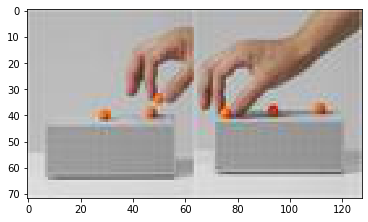


Ground truth labels:  ['magnetic', 'other', 'many', 'more', 'new', 'late']

image:  36f5fc45738d5c6300ca7e7c2f182d783ffa4e49.jpg
image_name:  /Users/manuelladron/phd_cd/DL_11785/project/Github_Ambiguity-in-Computational-Creativity-master/multilabel_classifier/dataset/images/36f5fc45738d5c6300ca7e7c2f182d783ffa4e49.jpg
predicted:  tensor([[ 158, 1985,  877]])
[[158, 1985, 877]]
sampled_ids:  [[158, 1985, 877]]
sampled_ids after moving to cpu and numpy:  [158, 1985, 877]
word:  available
word:  uber
word:  quick
sampled caption:  ['available', 'uber', 'quick']

Generated labels:  available uber quick


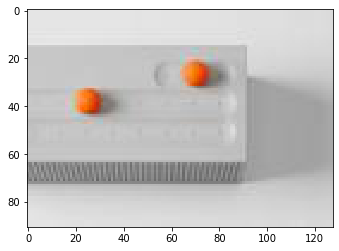


Ground truth labels:  ['magnetic', 'other', 'many', 'more', 'new', 'late']


In [186]:
generate_labels(dataset.train_data[0:20])

In [89]:
from ctcdecode import CTCBeamDecoder
from Levenshtein import distance as levenshtein_distance

In [ ]:
name =  dataset.train_data[1]

In [ ]:
dataset.labels[name]